# Financial Inclusion in Africa Starter Notebook


This is a simple starter notebook to get started with the Financial Inclusion Competition on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# from google.colab import files
import warnings
warnings.filterwarnings('ignore')

### 1. Load the dataset

In [2]:
# Load files into a pandas dataframe
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')
ss = pd.read_csv('data/SampleSubmission.csv')
variables = pd.read_csv('data/VariableDefinitions.csv')

In [3]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


The above output shows the number of rows and columns for train and test dataset. We have 13 variables in the train dataset, 12 independent variables and 1 dependent variable. In the test dataset, we have 12 independent variables.

We can observe the first five rows from our data set by using the head() method from the pandas library.

In [4]:
# inspect train data
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


We don't have missing data in our dataset.



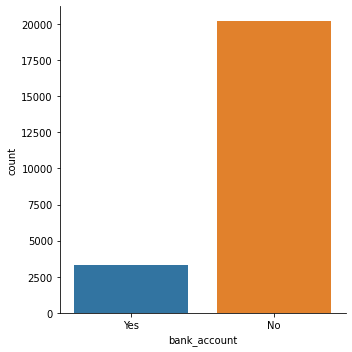

In [6]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train)

It is important to understand the meaning of each feature so you can really understand the dataset. You can read the VariableDefinition.csv file to understand the meaning of each variable presented in the dataset.

The SampleSubmission.csv gives us an example of how our submission file should look. This file will contain the uniqueid column combined with the country name from the Test.csv file and the target we predict with our model. Once we have created this file, we will submit it to the competition page and obtain a position on the leaderboard.


In [7]:
# view the submission file
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


### 2. Understand the dataset
We can get more information about the features presented by using the info() method from pandas.


In [8]:
 #show some information about the dataset
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


The output shows the list of variables/features, sizes, if it contains missing values and data type for each variable. From the dataset, we don’t have any missing values and we have 3 features of integer data type and 10 features of the object data type.

If you want to learn how to handle missing data in your dataset, we recommend you read How to [Handle Missing Data with Python](https://machinelearningmastery.com/handle-missing-data-python/) by Jason Brownlee.

We won’t go further on understanding the dataset because Davis has already published an article about exploratory data analysis (EDA) with the financial Inclusion in Africa dataset. You can read and download the notebook for EDA in the link below.

[Why you need to explore your data and how you can start](https://https://medium.com/analytics-vidhya/why-you-need-to-explore-your-data-how-you-can-start-13de6f29c8c1)

In [9]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


### 3. Data preparation for machine learning
Before you train the model for prediction, you need to perform data [cleaning](https://www.dataquest.io/blog/machine-learning-preparing-data/) and [preprocessing](https://towardsdatascience.com/data-preprocessing-concepts-fa946d11c825). This is a very important step; your model will not perform well without these steps.

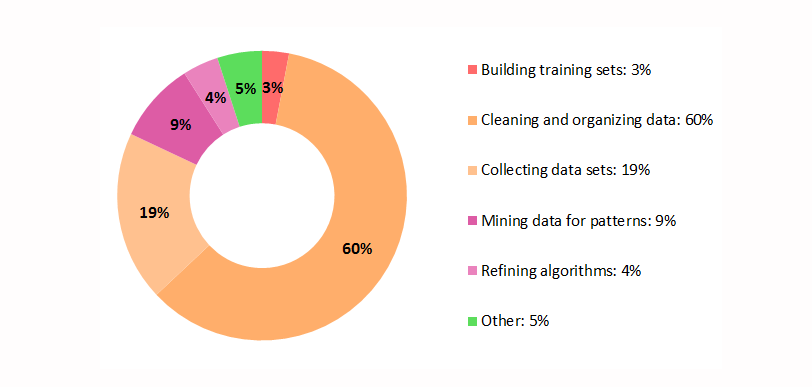

The first step is to separate the independent variables and target(bank_account) from the train data. Then transform the target values from the object data type into numerical by using [LabelEncoder](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd).


In [10]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Cobvert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int64


The target values have been transformed into numerical datatypes, **1** represents **‘Yes’** and **0** represents **‘No’**.

We have created a simple preprocessing function to:

*   Handle conversion of data types
*   Convert categorical features to numerical features by using [One-hot Encoder and Label Encoder](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)
*   Drop uniqueid variable
*   Perform [feature scaling](https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9).

The processing function will be used for both train and test independent variables.

In [11]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be onverted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    return data                  

Preprocess both train and test dataset.

In [12]:
# preprocess the train data 
processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(test)

Observe the first row in the train data.

In [13]:
# the first train row
print(processed_train[:1])

[[1.        0.        1.        0.1       0.0952381 0.        0.
  0.        0.        0.        0.        1.        0.        0.
  1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.       ]]


Observe the shape of the train data.

In [14]:
# shape of the processed train set
print(processed_train.shape)

(23524, 37)


In [15]:
# Save to csv
processed_train = pd.DataFrame(processed_train)
processed_test = pd.DataFrame(processed_test)

processed_train.to_csv('data/preprocessed_train.csv', index = False)
processed_test.to_csv('data/preprocessed_test.csv', index = False)

In [16]:
processed_test.shape

(10086, 37)

Now we have more independent variables than before (37 variables). This doesn’t mean all these variables are important to train our model. You need to select only important features that can increase the performance of the model. But we will not apply any feature selection technique in this article; if you want to learn and know more about feature selection techniques, we recommend you read the following articles:


*    [Introduction to Feature Selection methods with an example (or how to select the right variables?)](https://https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/)
*   [The 5 Feature Selection Algorithms every Data Scientist should know](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)
*   [How to Choose a Feature Selection Method For Machine Learning](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
*   [Feature Selection Techniques in Machine Learning with Python](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)

###4. Model Building and Experiments
A portion of the train data set will be used to evaluate our models and find the best one that performs well before using it in the test dataset.


In [17]:
import sklearn.model_selection

In [18]:
# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train, 
                                                  test_size = 0.1, random_state=42)

Only 10% of the train dataset will be used for evaluating the models. The parameter stratify = y_train will ensure an equal balance of values from both classes (‘yes’ and ‘no’) for both train and validation set.

There are many models to choose from such as 

*   [K Nearest Neighbors](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)
*   [Logistic Regression](https://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/)
*   [Random Forest](https://www.datacamp.com/community/tutorials/random-forests-classifier-python)

We will be using [**XGBoost**](https://www.datacamp.com/community/tutorials/xgboost-in-python). 

We will start by training these models using the train set after splitting our train dataset.

In [19]:
#import classifier algorithm here
from xgboost import XGBClassifier

# create models
xg_model = XGBClassifier()

#fitting the models
xg_model.fit(X_Train,y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The evaluation metric for this challenge will be the percentage of survey respondents for whom you predict the binary 'bank account' classification incorrectly.

This means the **lower** the incorrect percentage we get, the better the model performance.

In [20]:
# import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# evaluate the model
xg_y_model = xg_model.predict(X_Val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, xg_y_model))

Error rate of XGB classifier:  0.11177220569485757


Let’s check the confusion matrix for XGB model.

In [21]:
# %pip install --upgrade scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get confusion matrix for Gradient Boosting Classifier
ConfusionMatrixDisplay(xg_model,X_Val, y_val)

# predictions = clf.predict(X_test)
cm = confusion_matrix(processed_test, xg_y_model, labels=xg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xg_model.classes_)
disp.plot()
plt.show()

TypeError: ConfusionMatrixDisplay.__init__() takes 2 positional arguments but 4 were given

Our XGBoost model performs well on predicting **class 0** and performs poorly on predicting **class 1**, it may be caused by the imbalance of data provided(the target variable has more ‘No’ values than ‘Yes’ values). You can learn the best way to deal with imbalanced data here.

One way to increase the model performance is by applying the Grid search method as an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. You can skip this cell if you would like. 

In [ ]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Optimize model parameters
# I run this code in google colab to make the execution much faster and use the best params in the next code
param_grid = {'min_child_weighth': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }
my_xgb_model = GridSearchCV(xg_model, param_grid,n_jobs=-1,verbose=2,cv=5)
my_xgb_model.fit(X_Train, y_Train)
print(my_xgb_model.best_params_)        

Fitting 5 folds for each of 36 candidates, totalling 180 fits


TypeError: _fit_and_score() missing 1 required keyword-only argument: 'score_params'

The above source code will evaluate which parameter values for min_child_weight, gamma, subsample and max_depth will give us better performance.

Let’s use these parameter values and see if the XGB model performance will increase.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# fit by setting best parameters and Evaluate model
xgb_model = XGBClassifier(min_child_weight=1, gamma=1, subsample=0.8, max_depth=5)

xgb_model.fit(X_Train, y_Train)
y_pred = xgb_model.predict(X_Val)

# Get error rate
print("Error rate of the XGB classifier: ", 1 - accuracy_score(y_val, y_pred))

Error rate of the XGB classifier:  0.10837229069273269


Our XGB model has improved from the previous performance of **0.110** to **0.108**.


###5. Making the first submission
After improving the XGBoost model performance, let’s now see how the model performs on the competition test data set provided and how we rank on the competition leaderboard.

First, we make predictions on the competition test data set.

In [ ]:
# Get the predicted result for the test Data
test.bank_account = xgb_model.predict(processed_test)

Then we create a submission file according to the instruction provided in the SubmissionFile.csv.


In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

Let’s observe the sample results from our submission DataFrame.


In [ ]:
#show the five sample
submission.sample(5)

,uniqueid,bank_account
6062,uniqueid_12197 x Rwanda,0
2402,uniqueid_8471 x Kenya,1
4757,uniqueid_10892 x Rwanda,0
8590,uniqueid_8865 x Tanzania,0
3710,uniqueid_9845 x Rwanda,0


Save results in the CSV file.


In [ ]:
# Create submission csv file csv file
submission.to_csv('first_submission.csv', index = False)
files.download('first_submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We named our submission file a **first_submission.csv**. Now we can upload it to the Zindi competition page by clicking the submit button and selecting the file to upload., You also have an option to add comments for each submission.

###More Tips
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...

# ******************* GOOD LUCK!!! ***************************